In [1]:
%matplotlib inline

import os

import pandas as pd
import numpy as np

from scipy.stats import binned_statistic_2d

from matplotlib import pyplot as plt

PATH_TO_DATA = '../data'

In [2]:
data = pd.read_csv(os.path.join(PATH_TO_DATA, 'yellow_tripdata_2016-05.csv'), parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
regions = pd.read_csv(os.path.join(PATH_TO_DATA, 'regions.csv'), index_col=0, delimiter=';')

In [3]:
print(data.shape)
data.head()

(11836853, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


In [4]:
# bottom x left     and    top x right
longitude_bottom = -74.25559
longitude_top = -73.70001

latitude_left = 40.49612
latitude_right = 40.91553

def clean_data(df):
    query = 'passenger_count != 0 & trip_distance != 0 & tpep_pickup_datetime != tpep_dropoff_datetime & '+ \
    ' pickup_longitude > {} & pickup_longitude < {} & pickup_latitude > {} & pickup_latitude < {} '\
    .format(longitude_bottom, longitude_top, latitude_left, latitude_right)
    
    df = df.query(query)
    df['tpep_pickup_datetime'] = df['tpep_pickup_datetime'].apply(lambda x: x.replace(minute=0, second=0))
    
    return df

In [5]:
%%time
data = clean_data(data)

print(data.shape)

(11626521, 19)
Wall time: 1min 55s


C:\Users\Public\PythonProjects\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
%%time
binx=np.sort(regions.west.unique())[1:]
biny=np.sort(regions.south.unique())[1:]

x = data.pickup_longitude.values
y = data.pickup_latitude.values

_, _, _, regions_ids = binned_statistic_2d(x, y, regions, 'count', bins=[binx, biny])

regions_ids = regions_ids + 1

Wall time: 5.89 s


In [7]:
data['region'] = regions_ids

In [8]:
%%time
all_times = data['tpep_pickup_datetime'].view('int64')

binx = regions.index.values.tolist() + [2501]
biny = np.sort(all_times.unique()).tolist() + [np.datetime64('2016-06-01T00:00:00.000000000').view('int64')]

x = data.region.values
y = all_times

matrix, _, _, _ = binned_statistic_2d(x, y, None, 'count', bins=[binx, biny])

Wall time: 7.17 s


In [9]:
aggregated_df = pd.DataFrame(matrix, index=regions.index.values, columns= np.sort(data['tpep_pickup_datetime'].unique()))

In [10]:
latitude = 40.748817
longitude = -73.985428
query = 'west < {} & east > {} & south < {} & north > {}'.format(longitude, longitude, latitude, latitude)
region = regions.query(query).index.values[0]

print(region)

1231


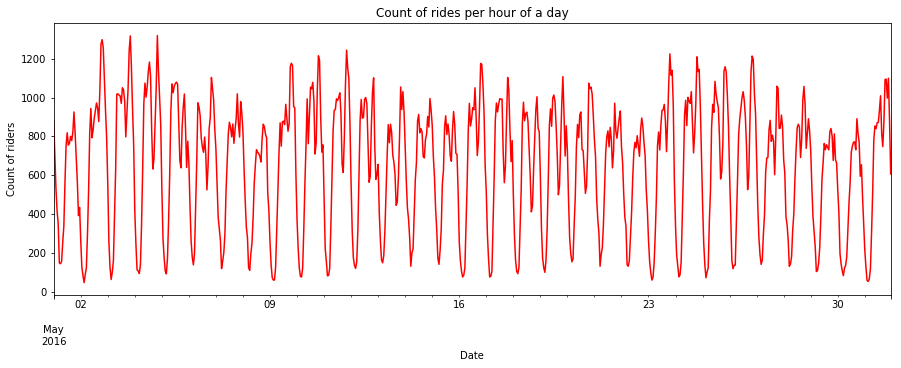

In [11]:
_ = plt.figure(figsize = (15,5))

aggregated_df.loc[region].plot(kind="line",color="r")
plt.title('Count of rides per hour of a day')
plt.xlabel('Date')
_ = plt.ylabel('Count of riders')

In [12]:
all_cells = aggregated_df.shape[0] * aggregated_df.shape[1]
empty_cells = matrix[matrix == 0].shape[0]
filled_cells = all_cells - empty_cells
pers = filled_cells / all_cells * 100

'All: {}, empty: {}, with rides: {}. Fill percentage: {}'.format(all_cells, empty_cells, filled_cells, pers)

'All: 1860000, empty: 1718238, with rides: 141762. Fill percentage: 7.621612903225807'

In [14]:
aggregated_df.to_csv(os.path.join(PATH_TO_DATA, 'aggregated_yellow_tripdata_2016-05.csv'))